In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, PReLU
from keras.optimizers import SGD , Adam, RMSprop
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline
%matplotlib inline

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

reward= -0.04


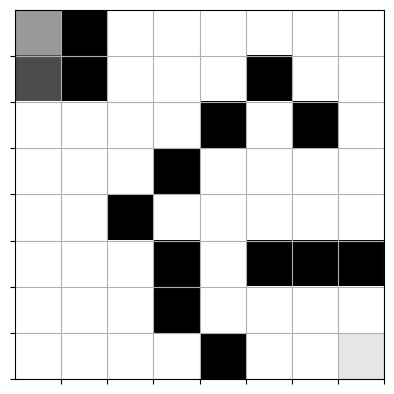

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # For each epoch:
    for epoch in range(n_epoch):
        loss = 0.0         
        n_episodes = 0     
    #   Agent_cell = randomly select a free cell
        agent_cell = random.choice(qmaze.free_cells)
    #   Reset the maze with agent set to above position
    #   Hint: Review the reset method in the TreasureMaze.py class.
        qmaze.reset(agent_cell)
    #   envstate = Environment.current_state
    #   Hint: Review the observe method in the TreasureMaze.py class.
        envstate = qmaze.observe()
    #   While state is not game over
        while qmaze.game_status() == 'not_over':
    #       previous_envstate = envstate
            previous_envstate = envstate 
    #       Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
            valid_actions = qmaze.valid_actions()
            if np.random.rand() < epsilon: 
                action = random.choice(valid_actions)
            else: 
                action = np.argmax(experience.predict(envstate))
            n_episodes += 1
    #       envstate, reward, game_status = qmaze.act(action)
    #   Hint: Review the act method in the TreasureMaze.py class.
            envstate, reward, game_status = qmaze.act(action) 
    #       episode = [previous_envstate, action, reward, envstate, game_status]
            episode = [previous_envstate, action, reward, envstate, game_over]
    #       Store episode in Experience replay object
    #   Hint: Review the remember method in the GameExperience.py class.
            experience.remember(episode)
    #       Train neural network model and evaluate loss
    #   Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method
    #         to train the model. You can call model.evaluate to determine loss.
            inputs, targets = experience.get_data()
            history = model.fit(inputs, targets, epochs = 8, batch_size = 16, verbose = 0)
            loss = model.evaluate(inputs, targets, verbose = 0)
      
            if game_status == 'win': #If the game_status is win
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                break
            elif game_status == 'lose': #If the game_status is lose
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                break

In [ ]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    for epoch in range(n_epoch):
    #   Intial variables
        game_over = False
        n_episodes = 0
        loss = 0.0
        
    #   Randomly set free cell as starting tile for agent
        agent_cell = random.choice(qmaze.free_cells)
    #   Reset the maze with agent set to above position
        qmaze.reset(agent_cell)
    #   Current State 
        envstate = qmaze.observe()
        
    
    #   While state is not game over:
        while not game_over:
            # Get valid actions
            valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break
            
            prev_envstate = envstate
            
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))
            
            #Take action
            envstate, reward, game_status = qmaze.act(action)
        
            # Update win history
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else: 
                game_over = False
            
            episode = [
                prev_envstate, 
                action, 
                reward, 
                envstate,
                game_status
            ]
            n_episodes += 1
            experience.remember(episode)
            
            inputs,targets = experience.get_data(data_size=data_size)
            
            # Train model
            history = model.fit(
                inputs, 
                targets, 
                epochs=12, 
                batch_size=32, 
                verbose=0
            )
            # Evaluate loss
            loss = model.evaluate(
                inputs, 
                targets, 
                verbose=0
            )
        
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize

In [9]:
# function that implements deep Q-learning algorithm
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    start_time = datetime.datetime.now()
    # Setting up the environment and game memory
    qmaze = TreasureMaze(maze)
    experience = GameExperience(model, max_memory=max_memory)
    
    # Initializing variables to zero
    win_history = []
    hsize = qmaze.maze.size // 2
    win_rate = 0.0
    

    for epoch in range(n_epoch):
        
        agent_cell = random.choice(qmaze.free_cells)
        qmaze.reset(agent_cell)
        loss = 0.0
        # Initialize the environment and get the initial state
        envstate = qmaze.observe()
        game = "playing"
        win_hx = []

        # Number of episodes for this epoch
        n_episodes = 0

        while game == "playing":
            valid_actions = qmaze.valid_actions()
            if not valid_actions:
                break
            prev_envstate = envstate
            
            # Choose an action using epsilon-greedy strategy
            if np.random.rand() < epsilon:
                # Explore environment randomly
                action = np.random.randint(0, num_actions)
            else:
                # Exploit previous action rewards, state
                q = model.predict(envstate)
                action = np.argmax(experience.predict(envstate))
                
            # Take the chosen action, get rewards and new state
            envstate, reward, game_status = qmaze.act(action)

            if game == "win":
                win_hx.append(1)
                game = "game_over"
            
            elif game_status == "lose":
                win_hx.append(0)
                game = "game_over"
            
            else:
                game = "playing"
                
            episode = [prev_envstate, action, reward, envstate, game_status]
            n_episodes += 1
            experience.remember(episode)
                
            inputs,targets = experience.get_data(data_size=data_size)
            history = model.fit(inputs, targets, epochs=8, batch_size=16, verbose=0)
            loss = model.evaluate(inputs, targets, verbose=0)

        


        if len(win_hx) > hsize:
            win_rate = sum(win_hx[-hsize:]) / hsize
        

        #Print the epoch, loss, episodes, win count, and win rate for each epoch
        win_rate = sum(win_history[-hsize:]) / min(hsize, len(win_history))
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))

        # Check for completion
        if win_rate == 1.0:
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break  
    
# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)  

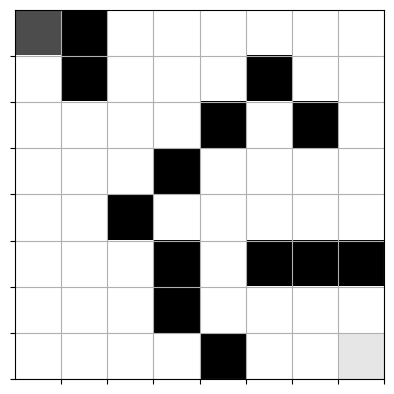

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In [11]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


KeyboardInterrupt: 

In [ ]:
completion_check(model, qmaze)
show(qmaze)

In [ ]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)